In [1]:
# uncomment below if you see a gribscan module not found error
#%pip install gribscan

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

In [4]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

## Extra-quick version: Get interpolated & averaged IFS-FESOM (TCo1279-NG5) production data and create quick plots

In [5]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")

In [6]:
# which IFS experiments are available?
print(list(cat.IFS))

['IFS_9-FESOM_5-production', 'IFS_4.4-FESOM_5-cycle3', 'IFS_9-FESOM_5-cycle3', 'IFS_9-NEMO_25-cycle3', 'IFS_28-NEMO_25-cycle3', 'IFS_4.4-FESOM_5-cycle3-nofastdata', 'IFS_4.4-FESOM_5-cycle3-fastdata', 'IFS_grids']


In [7]:
print(list(cat.IFS['IFS_9-FESOM_5-production']))

['2D_monthly_0.25deg', '3D_monthly_0.25deg']


In [8]:
ds = cat.IFS['IFS_9-FESOM_5-production']['2D_monthly_0.25deg'].to_dask() # load 0.25 degree here, monthly means

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 120, value: 1038240, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-02-01 2020-03-01 ... 2030-01-01
Dimensions without coordinates: value
Data variables: (12/60)
    100u     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    blh      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...       ...
    tisr     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tp       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tsr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tsrc     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ttr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ttrc     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          1003
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

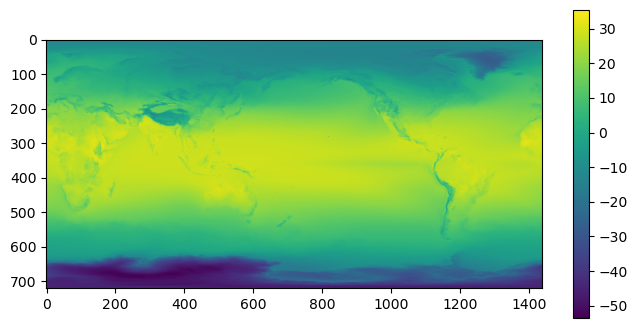

In [10]:
# reshape to (#lat x #lon) 10-yr mean of 2m temp
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
sample = np.reshape(ds['mean2t'].mean("time").values - 273.15, newshape=(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
plt.imshow(sample)
plt.colorbar()

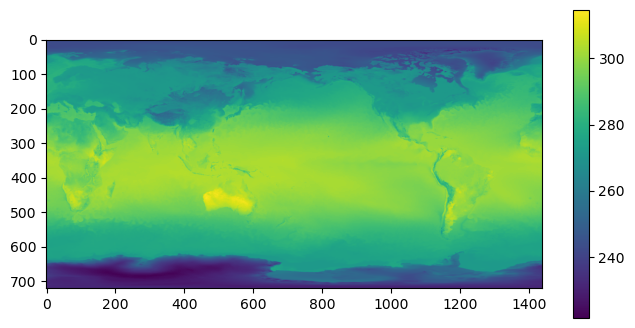

In [11]:
# reshape to (#lat x #lon) numpy array; stl1 is SST over the ocean
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
sample = np.reshape(ds['stl1'].isel(time=0).values, newshape=(len(np.unique(ds.lat)),len(np.unique(ds.lon))))
plt.imshow(sample)
plt.colorbar()

An imprecise global-mean can be computed as follows. For a precise grid-area weighted mean with cdo.fldmean(), see the example notebook [radiation_evaluation.ipynb](./radiation_evaluation.ipynb)

Text(0.5, 1.0, 'Global-mean 2m temperature time series')

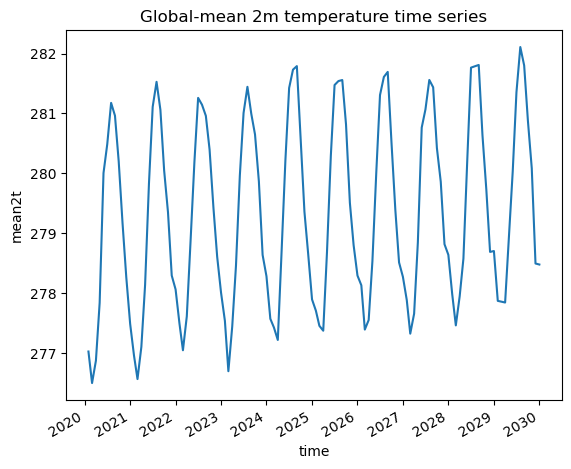

In [12]:
ds['mean2t'].mean("value").plot() # will need area-weighting
plt.title("Global-mean 2m temperature time series")

Text(0.5, 1.0, 'Zonal-mean total precipitation')

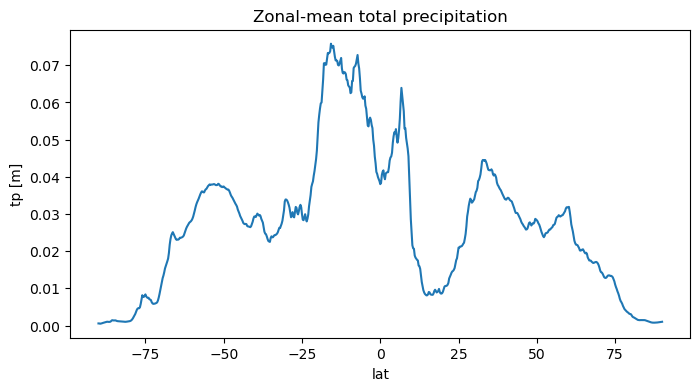

In [13]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
cat.IFS['IFS_9-FESOM_5-production']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].isel(time=0).groupby("lat").mean().plot(ax=ax)
plt.title('Zonal-mean total precipitation')

Text(0.5, 1.0, 'Hovmoeller plot of total precipitation')

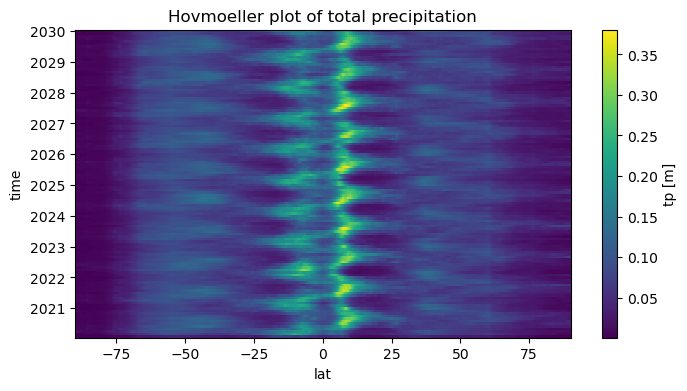

In [14]:
fig, ax = plt.subplots(figsize=(8,4), facecolor="white")
cat.IFS['IFS_9-FESOM_5-production']['2D_monthly_0.25deg'].to_dask().pipe(attach_coords)['tp'].groupby("lat").mean().plot(ax=ax)
plt.title('Hovmoeller plot of total precipitation')